## AIM: Find out why final cfacts have a too small extent which doestn match with the extent of fact and landsea mask

In [4]:
#!/usr/bin/env python3
# coding: utf-8

import glob
import itertools
import subprocess
# import pandas as pd
from datetime import datetime
from pathlib import Path

import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import attrici
import attrici.postprocess as pp
#import settings as s


In [5]:
variable = "tas"
lateral_sub = 1
storage_format = ".h5"
report_to_netcdf = [variable, variable + "_orig", "logp"]

input_dir = Path("/mnt/c/Users/Anna/Documents/UNI/PIK/automated_processing/notebooks/")
output_dir = Path("/mnt/c/Users/Anna/Documents/UNI/PIK/automated_processing/notebooks/")

source_file = (f"rechunked_ERA5_tas18_ERA5_1950_2020_t_00003_basd_redim_f_sm.nc") 
cfact_file = f"{source_file.split('.')[0]}_cfact.nc"


In [6]:

# append later with more variables if needed
vardict = {
    variable: "cfact",
    variable + "_orig": "y",
    # "mu":"mu",
    # "y_scaled": "y_scaled",
    # "pbern": "pbern",
    "logp": "logp",
}

cdo_ops = {
    # "monmean": "monmean ",
    "yearmean": "yearmean ",
    #    "monmean_valid": "monmean -setrtomiss,-1e20,1.1574e-06 -selvar,cfact,y",
    # "yearmean_valid": "yearmean -setrtomiss,-1e20,1.1574e-06 -selvar,cfact,y",
    "trend": "trend ",
    # "mse": "timmean -expr,'squared_error=sqr(mu-y_scaled)'"
    # "trend_valid": "trend -setrtomiss,-1e20,1.1574e-06 -selvar,cfact,y",
}

In [60]:
TIME0 = datetime.now()

source_file = Path(input_dir) / source_file
ts_dir = output_dir / "timeseries" / variable
cfact_dir = output_dir / "cfact" / variable
cfact_file = cfact_dir / cfact_file
cfact_rechunked = str(cfact_file).rstrip(".nc4") + "_rechunked.nc4"


In [9]:
def rescale_aoi(coord_list):
    '''
    Rescales aoi, returns rescaled indices of latitude or longitude starting from 0
    params:  
        coord_list: list of lat or lon coordinates of the aoi
    return: integer
    '''
    coord_indice = np.unique(coord_list,return_inverse= True )[1]
    return coord_indice.tolist()


In [58]:
data_gen = ts_dir.glob("**/*" + storage_format)
cfact_dir.mkdir(parents=True, exist_ok=True)

### check which data is available
data_list = []
lat_indices = []
lon_indices = []
lat_float_list = []
lon_float_list = []
for i in data_gen:
    data_list.append(str(i))
    lat_float = float(str(i).split("lat")[-1].split("_")[0])
    lon_float = float(str(i).split("lon")[-1].split(storage_format)[0])
    lat_float_list.append(lat_float)
    lon_float_list.append(lon_float)
    #lat_indices_old.append(int(180 - 2 * lat_float - 0.5))
    #lon_indices_old.append(int(2 * lon_float - 0.5 + 360))
lat_indices = rescale_aoi(lat_float_list)
lon_indices = rescale_aoi(lon_float_list)

print(len(pd.Series(lat_indices).unique()))
print(len(pd.Series(lon_indices).unique()))


8
843


In [18]:

# adjust indices if datasets are subsets (lat/lon-shapes are smaller than 360/720)
# TODO: make this more robust
lat_indices = np.array(np.array(lat_indices) / lateral_sub, dtype=int)
lon_indices = np.array(np.array(lon_indices) / lateral_sub, dtype=int)

#  get headers and form empty netCDF file with all meatdata
print(data_list[0])

# write empty outfile to netcdf with all orignal attributes
source_data = xr.open_dataset(source_file)
attributes = source_data[variable].attrs
coords = source_data[variable].coords

outfile = source_data.drop_vars(variable)


outfile.to_netcdf(cfact_file)
# open with netCDF4 for memory efficient writing
outfile = nc.Dataset(cfact_file, "a")

for var in report_to_netcdf:
    ncvar = outfile.createVariable(
        var,
        "f4",
        ("time", "lat", "lon"),
        chunksizes=(len(coords["time"]), 1, 1),
        fill_value=9.9692e36,
    )
    if var in [variable, variable + "_orig"]:
        for key, att in attributes.items():
            ncvar.setncattr(key, att)

outfile.setncattr("cfact_version", attrici.__version__)
outfile.setncattr("runid", Path.cwd().name)

n_written_cells = 0
print(len(lat_indices))
print(len(lon_indices))


for (i, j, dfpath) in itertools.zip_longest(lat_indices, lon_indices, data_list):
    #print(i, j, dfpath)
    df = pp.read_from_disk(dfpath)
    for var in report_to_netcdf:
        ts = df[vardict[var]]
        outfile.variables[var][:, i, j] = np.array(ts) 
    n_written_cells = n_written_cells + 1

outfile.close()


/mnt/c/Users/Anna/Documents/UNI/PIK/automated_processing/notebooks/timeseries/tas/lat_62.35833333333335/ts_ERA5_lat62.35833333333335_lon21.225000000000062.h5


6619
6619
0 7 /mnt/c/Users/Anna/Documents/UNI/PIK/automated_processing/notebooks/timeseries/tas/lat_62.35833333333335/ts_ERA5_lat62.35833333333335_lon21.225000000000062.h5
0 8 /mnt/c/Users/Anna/Documents/UNI/PIK/automated_processing/notebooks/timeseries/tas/lat_62.35833333333335/ts_ERA5_lat62.35833333333335_lon21.241666666666728.h5
0 9 /mnt/c/Users/Anna/Documents/UNI/PIK/automated_processing/notebooks/timeseries/tas/lat_62.35833333333335/ts_ERA5_lat62.35833333333335_lon21.2583333333334.h5
0 12 /mnt/c/Users/Anna/Documents/UNI/PIK/automated_processing/notebooks/timeseries/tas/lat_62.35833333333335/ts_ERA5_lat62.35833333333335_lon21.308333333333398.h5
0 15 /mnt/c/Users/Anna/Documents/UNI/PIK/automated_processing/notebooks/timeseries/tas/lat_62.35833333333335/ts_ERA5_lat62.35833333333335_lon21.358333333333395.h5
0 16 /mnt/c/Users/Anna/Documents/UNI/PIK/automated_processing/notebooks/timeseries/tas/lat_62.35833333333335/ts_ERA5_lat62.35833333333335_lon21.37500000000006.h5
0 17 /mnt/c/Users/

RuntimeError: NetCDF: Index exceeds dimension bound

--> FIXME: currently only first row of lats is written to nc file

##  reload first intermediate cfact 

In [62]:
lsm = xr.load_dataset("/mnt/c/Users/Anna/Documents/UNI/PIK/automated_processing/notebooks/landmask_00003.nc")
print("Number of land cells in lsm", lsm["area_European_01min"].count().values)

cfact = xr.load_dataset(cfact_file)
print("Number of land cells in cfact ", cfact.tas[10,:,:].count().values)

cfact["tas"][10,:,:]


Number of land cells in lsm 395683
Number of land cells in cfact  114


<xarray.DataArray 'tas' (lat: 3, lon: 129)>
array([[      nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan, 268.88107, 268.86908, 268.80838,
        268.72095, 268.68427, 268.61465, 268.25424, 268.11246, 268.11154,
        268.10187, 268.15106, 267.96317, 267.83105, 267.76804, 267.7121 ,
        267.51822, 267.61926, 267.52176, 267.02643, 267.0401 , 266.98788,
        266.8104 , 266.83234, 266.5633 , 266.18723, 265.98364, 265.87115,
        265.95273, 265.71933, 265.8897 , 265.41986, 265.44318, 265.2578 ,
        265.24475, 265.24017, 265.34412, 264.7593 , 264.77872, 264.71692,
        264.6335 , 264.67978, 264.8581 , 264.5535 , 264.56693, 264.52145,
        264.55182, 264.51105, 264.44775, 263.98322, 263.99823, 263.9998 ,
        264.11478, 264.16437, 264.08228, 263.8184 , 263.56805, 263.43524,
        263.39105, 263.30707, 263.29248, 262.99396, 262.878  , 262.90103,
        262.9092 , 262.9112 , 262.92725, 262.7528 , 262.79562, 262.7226 ,
        262.7227 , 262.68387, 262.66238, 262.75278, 262.73138, 262.67212,
        262.72794, 262.67194, 262.5656 , 262.579  , 262.64142, 262.57498,
        262.64166, 262.60587, 262.56613, 262.65524, 262.71375, 262.61932,
        262.6445 , 262.61816, 262.69614, 262.62915, 262.52762, 262.5543 ,
        262.5408 , 262.53323, 262.47318, 262.23907, 262.25827, 262.25858,
        262.29514, 262.23245, 262.2309 , 262.13696, 262.04385, 262.01312,
...
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan]], dtype=float32)
Coordinates:
  * lat      (lat) float64 62.39 62.38 62.36
  * lon      (lon) float64 21.26 21.28 21.29 21.31 ... 23.34 23.36 23.38 23.39
    time     datetime64[ns] 1950-01-12T18:00:00
Attributes:
    code:     167
    table:    128

In [64]:
np.nanmean(cfact["tas"][10,:,:].values)


264.27686

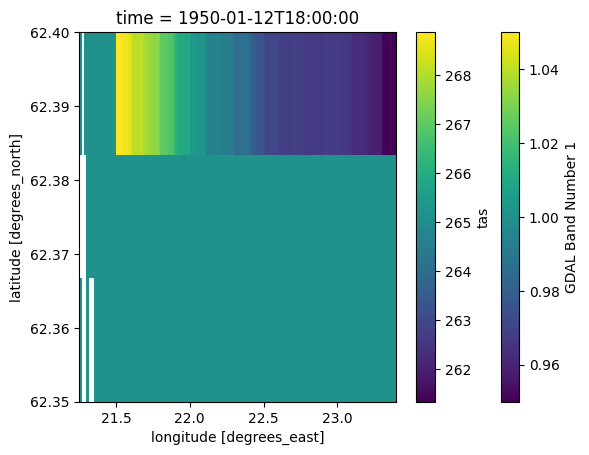

In [66]:
lsm.area_European_01min[:,:].plot()
cfact.tas[10, :,:].plot()


### Rechunk cfact
Fix rechunk part according to git issues

In [35]:
# rechunk = True 
# replace_invalid = True
# cdo_processing = False

# if rechunk:
#     cfact_rechunked = pp.rechunk_netcdf(cfact_file, cfact_rechunked)

# if replace_invalid:
#     cfact_rechunked = pp.replace_nan_inf_with_orig(
#         s.variable, source_file, cfact_rechunked
#     )


# if cdo_processing:

#     for cdo_op in cdo_ops:

#         outfile = str(cfact_file).rstrip(".nc4") + "_" + cdo_op + ".nc4"
#         if "trend" in cdo_op:
#             outfile = (
#                 outfile.rstrip(".nc4") + "_1.nc4 " + outfile.rstrip(".nc4") + "_2.nc4"
#             )
#         try:
#             cmd = "cdo " + cdo_ops[cdo_op] + " " + cfact_rechunked + " " + outfile
#             print(cmd)
#             subprocess.check_call(cmd, shell=True)
#         except subprocess.CalledProcessError:
#             cmd = "module load cdo && " + cmd
#             print(cmd)
#             subprocess.check_call(cmd, shell=True)
